# <span style="color:#1E90FF"> Итоговый проект</span>

### <span style="color:#1E90FF"> Бриф “Агентство недвижимости”</span>

#### <span style="color:#1E90FF"> Проблематика:</span>
- Риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях

#### <span style="color:#1E90FF"> Что необходимо сделать: </span>
- разработать сервис для предсказания стоимости домов на основе истории предложений.

In [2]:
#загрузка модулей

# инструменты анализа и обработки данных
import pandas as pd
import numpy as np
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px

# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import plotly.graph_objects as go

## <span style="color:#1E90FF"> Анализ и обработка данных</span>

In [3]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final project/data.csv')

#### Загрузка датасета

In [4]:
df = pd.read_csv('data/data.csv')
#df = data

df.head(3)

status private pool        propertyType             street    baths  \
0    Active          NaN  Single Family Home     240 Heather Ln      3.5   
1  for sale          NaN  single-family home  12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home  2005 Westridge Rd  2 Baths   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000

## <span style="color:#1E90FF"> Baseline </span>

#### <span style="color:#1E90FF"> Для Baseline подготовим датасет с числовыми характеристиками и проведем минимальную обработку </span>

In [5]:
df_baseline = df.drop(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId'], axis=1)
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   sqft     336608 non-null  object
 1   zipcode  377185 non-null  object
 2   target   374704 non-null  object
dtypes: object(3)
memory usage: 8.6+ MB


Оставлены три колонки:
zipcode - содержит в себе адрес объекта недвижимости;
sqft - площадь объекта недвижимости, как правило основная переменная, влияющая на стоимость;
target - целевая переменная.

### <span style="color:#1E90FF"> Подготовка данных для Baseline </span>

#### <span style="color:#1E90FF"> target </span>

In [6]:
# преобразование типа object в тип float

df_baseline['target'] = df_baseline['target'].str.replace(",", "")
df_baseline['target'] = df_baseline['target'].str.replace("$", "")
df_baseline['target'] = df_baseline['target'].str.replace(r'\D', '')
df_baseline['target'] =pd.to_numeric(df_baseline['target'])

#### <span style="color:#1E90FF"> sqft </span>

In [7]:
# изменение типа object в тип float

df_baseline['sqft'] = df_baseline['sqft'].str.replace(r'\D', '')
df_baseline['sqft'] =pd.to_numeric(df_baseline['sqft'])

#### <span style="color:#1E90FF"> zipcode </span>

In [8]:
# изменение типа object в тип float

df_baseline['zipcode'] = pd.to_numeric(df_baseline['zipcode'], errors = 'coerce')

In [9]:
# количество пропусков в подготовленном датасете
df_baseline.isnull().sum()

sqft       41397
zipcode      242
target      2481
dtype: int64

<span style="color:#1E90FF"> удаление пропусков поочередно по каждому из признаков, чтобы сохранить максимальное количество строк </span>

In [10]:
df_baseline_cleaned = df_baseline.dropna(subset=['sqft']).reset_index(drop=True)


In [11]:
df_baseline_cleaned = df_baseline_cleaned.dropna(subset=['target']).reset_index(drop=True)


In [12]:
df_baseline_cleaned = df_baseline_cleaned.dropna(subset=['zipcode']).reset_index(drop=True)
df_baseline_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333554 entries, 0 to 333553
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sqft     333554 non-null  float64
 1   zipcode  333554 non-null  float64
 2   target   333554 non-null  float64
dtypes: float64(3)
memory usage: 7.6 MB


#### <span style="color:#1E90FF"> Подготовка модели. Для сравнения результатов в качестве метрики выбрана R2 </span>

In [13]:
# создание датасета для обучения и целевой переменной
X = df_baseline_cleaned.drop(['target'], axis=1)
y = df_baseline_cleaned.target.values

In [14]:
# разделение датасета
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [15]:
# функция для обучения моделей

df_models = pd.DataFrame(data=None, columns=['Algorithm', 'r2_train', 'r2_test'])

def make_model(X_tr, X_te, y_tr, y_te, model, model_name: str): 
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    r2_train = r2_score(y_tr, y_pred_train)
    r2_test = r2_score(y_te, y_pred_test)
    df_models.loc[len(df_models.index)] = [model_name, r2_train, r2_test]
                       

make_model(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression')
make_model(X_train, X_test, y_train, y_test, Ridge(), 'Ridge')
make_model(X_train, X_test, y_train, y_test, Lasso(), 'Lasso')
make_model(X_train, X_test, y_train, y_test, ElasticNet(), 'ElasticNet')
make_model(X_train, X_test, y_train, y_test, CatBoostRegressor(), 'CatBoostRegression')
make_model(X_train, X_test, y_train, y_test, GradientBoostingRegressor(), 'GradientBoosting')
make_model(X_train, X_test, y_train, y_test, RandomForestRegressor(), 'RandomForest')
make_model(X_train, X_test, y_train, y_test, XGBRegressor(), 'XGBoost')

Learning rate set to 0.098976
0:	learn: 1675723.7453095	total: 62.3ms	remaining: 1m 2s
1:	learn: 1629409.8376883	total: 68.8ms	remaining: 34.3s
2:	learn: 1588515.6505836	total: 75.6ms	remaining: 25.1s
3:	learn: 1556318.4512358	total: 81.6ms	remaining: 20.3s
4:	learn: 1527158.1348295	total: 87.5ms	remaining: 17.4s
5:	learn: 1500323.7469948	total: 93.1ms	remaining: 15.4s
6:	learn: 1474118.5910586	total: 99.2ms	remaining: 14.1s
7:	learn: 1456029.4008660	total: 107ms	remaining: 13.3s
8:	learn: 1436399.0989961	total: 114ms	remaining: 12.5s
9:	learn: 1423119.0863159	total: 118ms	remaining: 11.7s
10:	learn: 1408354.0098057	total: 123ms	remaining: 11.1s
11:	learn: 1396756.5323330	total: 128ms	remaining: 10.5s
12:	learn: 1386053.8080263	total: 133ms	remaining: 10.1s
13:	learn: 1372674.0873021	total: 138ms	remaining: 9.74s
14:	learn: 1359576.0740377	total: 143ms	remaining: 9.42s
15:	learn: 1351619.9007651	total: 149ms	remaining: 9.16s
16:	learn: 1338870.2069467	total: 154ms	remaining: 8.89s
17:	

In [16]:
# график сравнения результатов предсказания моделей на тренировочном и тестовом наборе

fig = go.Figure(data=[
    go.Bar(name='r2_train', x=df_models.Algorithm, y=df_models.r2_train),
    go.Bar(name='r2_test', x=df_models.Algorithm, y=df_models.r2_test)
])
fig.update_layout(template='plotly_dark', title='R2 для train и test', title_x=0.5)

Число выбросов по методу z-отклонения: 4357
Результирующее число записей: 329197


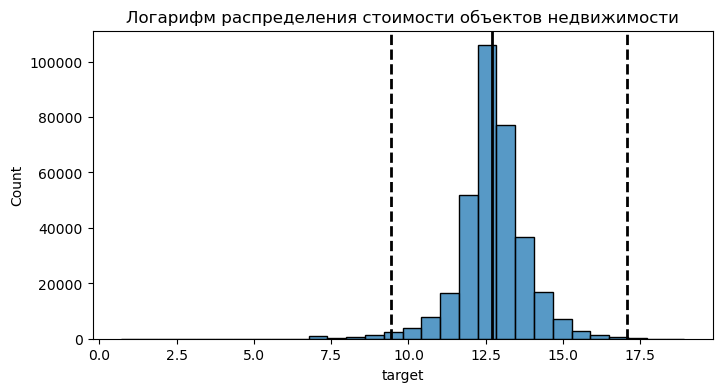

In [17]:
# построение графика для оценки нормальности распределения данных

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_age = np.log(df_baseline_cleaned['target'] + 1)
histplot = sns.histplot(log_age, bins=30, ax=ax)
histplot.axvline(log_age.mean(), color='k', lw=2)
histplot.axvline(log_age.mean()+ 4 *log_age.std(), color='k', ls='--', lw=2)
histplot.axvline(log_age.mean()- 3 *log_age.std(), color='k', ls='--', lw=2)
histplot.set_title('Логарифм распределения стоимости объектов недвижимости');

# функция для оценки нахождения значений в пределеах +/- 3-сигма
def outliers_z_score_mod(data, feature, log_scale=True, left=3, right=4):

    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
    

outliers, cleaned = outliers_z_score_mod(df_baseline_cleaned, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

In [18]:
X = cleaned.drop(['target'], axis=1)
y = cleaned.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [19]:
# функция для обучения моделей

df_models = pd.DataFrame(data=None, columns=['Algorithm', 'r2_train', 'r2_test'])
                     
make_model(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression')
make_model(X_train, X_test, y_train, y_test, Ridge(), 'Ridge')
make_model(X_train, X_test, y_train, y_test, Lasso(), 'Lasso')
make_model(X_train, X_test, y_train, y_test, ElasticNet(), 'ElasticNet')
make_model(X_train, X_test, y_train, y_test, CatBoostRegressor(), 'CatBoostRegression')
make_model(X_train, X_test, y_train, y_test, GradientBoostingRegressor(), 'GradientBoosting')
make_model(X_train, X_test, y_train, y_test, RandomForestRegressor(), 'RandomForest')
make_model(X_train, X_test, y_train, y_test, XGBRegressor(), 'XGBoost')

Learning rate set to 0.09877
0:	learn: 1140257.0977375	total: 5.93ms	remaining: 5.92s
1:	learn: 1106018.0584449	total: 15.2ms	remaining: 7.6s
2:	learn: 1076759.6770739	total: 27.4ms	remaining: 9.12s
3:	learn: 1051822.8601270	total: 33.8ms	remaining: 8.43s
4:	learn: 1030977.8707696	total: 39.4ms	remaining: 7.83s
5:	learn: 1008445.7271715	total: 45.8ms	remaining: 7.58s
6:	learn: 992128.8649419	total: 50.8ms	remaining: 7.21s
7:	learn: 978022.8709444	total: 55.9ms	remaining: 6.93s
8:	learn: 965226.4973624	total: 62.3ms	remaining: 6.85s
9:	learn: 952582.9943919	total: 67.4ms	remaining: 6.68s
10:	learn: 943200.1257984	total: 72.6ms	remaining: 6.53s
11:	learn: 933560.7675956	total: 78.3ms	remaining: 6.45s
12:	learn: 921437.0237128	total: 83.7ms	remaining: 6.35s
13:	learn: 913991.2075867	total: 89.1ms	remaining: 6.27s
14:	learn: 908012.0436090	total: 94.6ms	remaining: 6.21s
15:	learn: 901864.6213090	total: 100ms	remaining: 6.17s
16:	learn: 893566.9524552	total: 107ms	remaining: 6.2s
17:	learn:

In [20]:
# график сравнения результатов предсказания моделей на тренировочном и тестовом наборе

fig = go.Figure(data=[
    go.Bar(name='r2_train', x=df_models.Algorithm, y=df_models.r2_train),
    go.Bar(name='r2_test', x=df_models.Algorithm, y=df_models.r2_test)
])
fig.update_layout(template='plotly_dark', title='R2 для train и test', title_x=0.5)

#### <span style="color:#32CD32"> Выводы:</span>
- для Baseline без замены пропусков RandomForest показал относительно неплохой результат.
- полученный результат будет использован для сравнения результатов, полученных после обработки данных и подбора других алгоритмов ML.

## <span style="color:#1E90FF"> Разведывательный и первичный анализ данных </span>


In [21]:
# предварительная оценка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [22]:
# поиск пропусков в столбцах
null_data = df.isnull().sum().sort_values()
print(f'\nСтолбцы с пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с пропусками данных:
street               2
city                34
target            2481
propertyType     34733
status           39918
sqft             40577
MlsId            66880
beds             91282
baths           106338
stories         150715
fireplace       274070
PrivatePool     336874
mls-id          352243
private pool    373004
dtype: int64


In [23]:
# поиск дубликатов
df.duplicated().sum()

50

In [24]:
# удаление дубликатов
df = df.drop_duplicates()

# поиск дубликатов
df.duplicated().sum()

0

#### <span style="color:#32CD32"> Выводы:</span>
- датасет содержит 17 столбцов; 
- в 14 из 17 столбцах присутствуют пропуски;
- датасете содержал 50 дубликатов;
- все столбцы имеют тип 'object'.

## <span style="color:#1E90FF"> Преобразование параметра 'target' </span>

In [25]:
# копирование датасета для дальнейшей его обработки
df_target = df.copy()

In [26]:
# преобразование типа object в тип float

df_target['target'] = df_target['target'].str.replace(",", "")
df_target['target'] = df_target['target'].str.replace("$", "")
df_target['target'] = df_target['target'].str.replace(r'\D', '')
df_target['target'] =pd.to_numeric(df_target['target'])

#### <span style="color:#1E90FF"> Оценка содержания параметра target </span>

In [27]:
df_target['target'].describe()

count    3.746550e+05
mean     6.447596e+05
std      1.841482e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.820000e+05
max      1.950000e+08
Name: target, dtype: float64

In [28]:
df_target[df_target['target'] > 100000000].head()

status private pool        propertyType               street  \
54164   for sale          NaN  single-family home  2571 Wallingford Dr   
110083  for sale          NaN  single-family home         Tortuoso Way   
119862  For sale          NaN       Single Family   141 S Carolwood Dr   
132425  For sale          NaN       Single Family         875 Nimes Rd   
143528  for sale          NaN  single-family home   67 Beverly Park Ct   

           baths                                          homeFacts fireplace  \
54164   24 Baths  {'atAGlanceFacts': [{'factValue': '2000', 'fac...       yes   
110083       NaN  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   
119862      10.0  {'atAGlanceFacts': [{'factValue': '1936', 'fac...       Yes   
132425      18.0  {'atAGlanceFacts': [{'factValue': '1935', 'fac...       Yes   
143528  23 Baths  {'atAGlanceFacts': [{'factValue': '1998', 'fac...       yes   

                 city                                            schools  \
54164   Beverly Hills  [{'rating': ['7/10', '5/10', '10/10'], 'data':...   
110083    Los Angeles  [{'rating': ['7/10', '5/10', '10/10'], 'data':...   
119862    Los Angeles  [{'rating': ['10/10', '5/10', '7/10'], 'data':...   
132425    Los Angeles  [{'rating': ['10/10', '7/10'], 'data': {'Dista...   
143528  Beverly Hills  [{'rating': ['7/10', '5/10', '10/10'], 'data':...   

               sqft zipcode     beds state stories mls-id PrivatePool  \
54164   38,000 sqft   90210  12 Beds    CA     2.0    NaN         yes   
110083          NaN   90077      NaN    CA     NaN    NaN         yes   
119862       12,201   90077        9    CA       3    NaN         Yes   
132425           --   90077       11    CA       2    NaN         Yes   
143528  28,660 sqft   90210  20 Beds    CA     3.0    NaN         yes   

           MlsId       target  
54164   19512408  110000000.0  
110083  19525850  150000000.0  
119862  19479370  115000000.0  
132425  18398466  195000000.0  
143528  18386780  165000000.0

In [29]:
print(df_target[df_target['target'] >100000000].shape[0])

9


##### <span style="color:#1E90FF"> Объекты со стоимостью более миллиарда согласно описания очень большие особняки, но их из всей выборки 9, что может некорректно влиять на обучени моделей и будет восприниматься как выбросы. Для корректности эти строки будут удалены. </span>

In [30]:
print(df_target[df_target['target'] < 100].shape[0])

22


##### <span style="color:#1E90FF"> Объекты ценой менее 100, тоже выглядят очень сомнительно, тем более их не так много. Для корректности они также будут удалены </span>

In [31]:
# удаление объектов недвижимости со стоимостью 100
df_target = df_target[df_target.target > 100]

# удаление объектов недвижимости со стоимостью более 100 миллионов

df_target = df_target[df_target.target < 100000000]

In [32]:
df_target['target'].describe()

count    3.746240e+05
mean     6.414656e+05
std      1.705601e+06
min      2.500000e+02
25%      1.869990e+05
50%      3.200000e+05
75%      5.820000e+05
max      9.800000e+07
Name: target, dtype: float64


##### <span style="color:#1E90FF"> Оценка нормальности распределения параметра target </span>

In [33]:
data = df_target.reset_index(drop=True)

In [34]:
import scipy

In [35]:
# оценка нормальности по критерию Шапиро
from scipy.stats import shapiro

stat, p = scipy.stats.shapiro(df_target['target']) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.242, p-value=0.000
Отклонить гипотезу о нормальности


In [36]:
# оценка нормальности по критерию Пирсона
stat, p = scipy.stats.normaltest(df_target['target']) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=765435.739, p-value=0.000
Отклонить гипотезу о нормальности


array([[<Axes: title={'center': 'target'}>]], dtype=object)

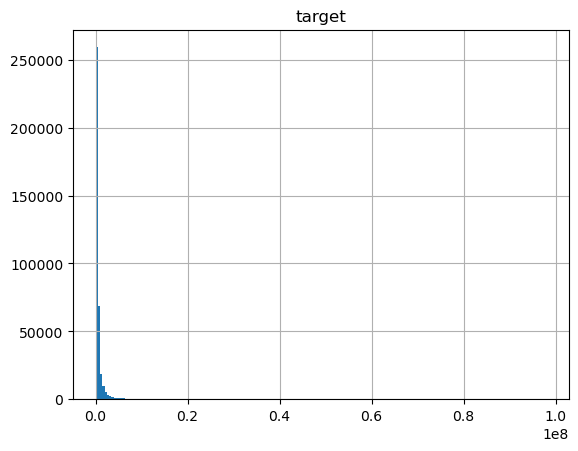

In [37]:
data.hist(bins=200)


array([[<Axes: title={'center': 'target'}>]], dtype=object)

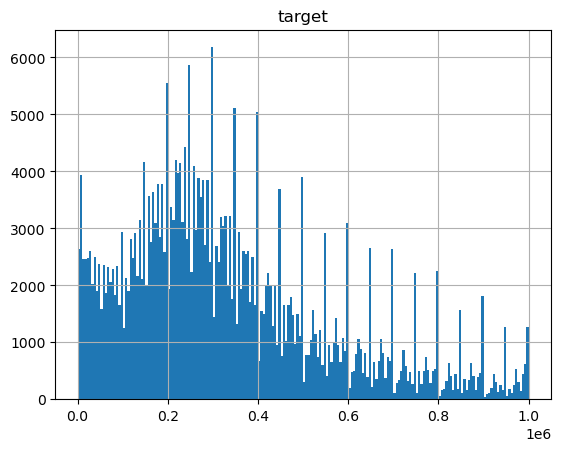

In [38]:
data = df_target[df_target['target'] < 1000000]
data.hist(bins=200)

##### <span style="color:#1E90FF"> Цены продаваемых объектов распределены ненормально, имеется большое количество дешёвой недвижимости и "хвост" с увеличивающейся стоимостью. Для оценки этих групп объектов будут рассмотрены типы недвижимости и другие параметры, чтобы определить является ли это ошибкой. </span>

#### <span style="color:#1E90FF"> Оценка параметров fireplace, mls-id и Mlsid на стоимость (target) </span>

In [39]:
df_target.head(3)

status private pool        propertyType             street    baths  \
0    Active          NaN  Single Family Home     240 Heather Ln      3.5   
1  for sale          NaN  single-family home  12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home  2005 Westridge Rd  2 Baths   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   

      target  
0   418000.0  
1   310000.0  
2  2895000.0

In [40]:
# визуализируем различия в стоимости, в зависимости от категории 'fireplace':

data = df_target.dropna(subset=['target']).groupby('fireplace')['target'].agg('mean').reset_index().sort_values(by='fireplace')
px.scatter(data, x='fireplace', y='target', size_max=30, size='target', color='target')

##### <span style="color:#32CD32"> Можно отметить, что явной зависимости между переменной Fireplace и target нет. Колонка Fireplace будет удалена. </span>

##### <span style="color:#1E90FF"> Колонки 'mls-id' и 'MlsId'. Очевидно, что это дублирующие колонки, их необходимо объединить. </span>

In [41]:
df_target['MlsId'] = np.where(df_target['MlsId'].isnull(), 0, 1)
df_target['mls-id'] = np.where(df_target['mls-id'].isnull(), 0, 1)

df_target['mlsid'] = df_target["mls-id"] + df_target["MlsId"]

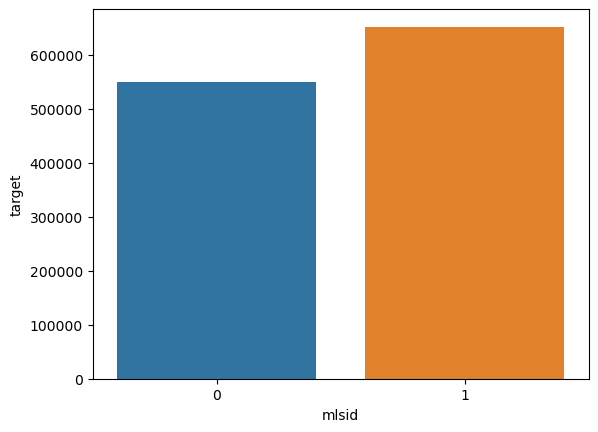

In [42]:
# средняя цена продаваемого объекта в зависимости от наличия id
data = df_target.groupby('mlsid')['target'].agg('mean').reset_index().sort_values(by='mlsid')
sns.barplot(data=data, x="mlsid", y="target")
plt.show()

##### <span style="color:#32CD32"> Значительной разницы в стоимости объектов недвижимости нет при наличии и отсутствии риелтора. Столбцы с mlsid можно удалить.</span>

In [43]:
# удаление столбцов с mlsid и fireplace

df_target = df_target.drop(['MlsId', 'mls-id', 'mlsid', 'fireplace'], axis=1)
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374624 entries, 0 to 377184
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335370 non-null  object 
 1   private pool  4151 non-null    object 
 2   propertyType  340078 non-null  object 
 3   street        374622 non-null  object 
 4   baths         269292 non-null  object 
 5   homeFacts     374624 non-null  object 
 6   city          374590 non-null  object 
 7   schools       374624 non-null  object 
 8   sqft          334539 non-null  object 
 9   zipcode       374624 non-null  object 
 10  beds          283708 non-null  object 
 11  state         374624 non-null  object 
 12  stories       224889 non-null  object 
 13  PrivatePool   40112 non-null   object 
 14  target        374624 non-null  float64
dtypes: float64(1), object(14)
memory usage: 45.7+ MB


#### <span style="color:#1E90FF"> Оценка распределения стоимости объектов недвижимости в зависимости от города </span>

In [44]:
# визуализируем различия в стоимости, в зависимости от категории 'status':

data = df_target.dropna(subset=['target']).groupby('city')['target'].agg('mean').reset_index().sort_values(by='city')
px.scatter(data, x='city', y='target', size_max=30, size='target', color='target')

In [45]:
df_target = df_target.drop(['city'], axis=1)

#### <span style="color:#32CD32"> Выводы:</span>
- Из полученного графика видно, что нет какого-либо города, в котором бы была только очень дешевая недвижимость или только дорогая. Одназначного тренда нет. 
- Колонку 'city' можно удалить, также информация о городе содержится в почтовом индексе.

## <span style="color:#1E90FF"> Обработка переменной 'PrivatePool' 'private pool' </span>

In [46]:
# копирование датасета перед внесением изменений
df_pool = df_target.copy()

In [47]:
# замена пропусков в колонках на 0, наличие бассейна меняется на 1
df_pool['PrivatePool'] = np.where(df_pool['PrivatePool'].isnull(), 0, 1)
df_pool['private pool'] = np.where(df_pool['private pool'].isnull(), 0, 1)

In [48]:
# объединение колонок, для заполнения пропусков
df_pool['pool'] = df_pool["private pool"] + df_pool["PrivatePool"]

In [49]:
df_pool['pool'].value_counts()

0    330361
1     44263
Name: pool, dtype: int64

In [50]:
# удаление ненужных колонок после объединения
df_pool = df_pool.drop(['private pool', 'PrivatePool'], axis=1)

In [51]:
df_pool.head(3)

status        propertyType             street    baths  \
0    Active  Single Family Home     240 Heather Ln      3.5   
1  for sale  single-family home  12911 E Heroy Ave  3 Baths   
2  for sale  single-family home  2005 Westridge Rd  2 Baths   

                                           homeFacts  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...   

                                             schools        sqft zipcode  \
0  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...        2900   28387   
1  [{'rating': ['4/10', 'None/10', '4/10'], 'data...  1,947 sqft   99216   
2  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...  3,000 sqft   90049   

     beds state stories     target  pool  
0       4    NC     NaN   418000.0     0  
1  3 Beds    WA     2.0   310000.0     0  
2  3 Beds    CA     1.0  2895000.0     1

<Axes: xlabel='pool', ylabel='target'>

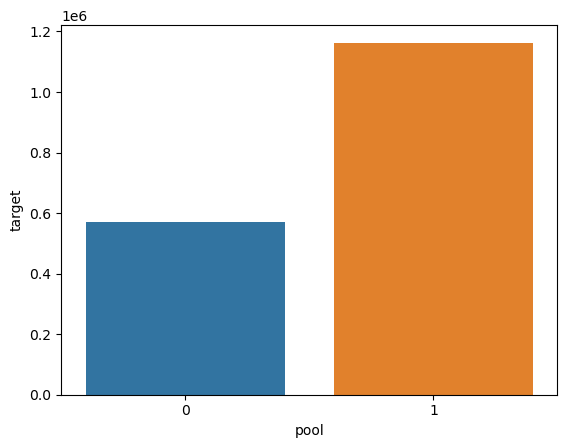

In [52]:
# средняя цена продаваемого объекта в зависимости от наличия бассейна
data = df_pool.groupby('pool')['target'].agg('mean').reset_index().sort_values(by='pool')
sns.barplot(data=data, x="pool", y="target")

#### <span style="color:#32CD32"> Вывод:</span>
  - наличие бассейна существенным образом влияет на цену недвижимости
  - колонка о наличие бассейна останется

### <span style="color:#1E90FF"> Оценка зависимости цены 'target' от статуса 'status'</span>

In [53]:
# копирование датасета перед внесением изменений
df_status = df_pool.copy()

In [54]:
# оценка распределения видов статуса
df_status['status'].value_counts(normalize=True).head(20)

for sale                     0.465304
Active                       0.313660
For sale                     0.129588
foreclosure                  0.016910
New construction             0.016275
Pending                      0.014005
Pre-foreclosure              0.005964
P                            0.004437
Pre-foreclosure / auction    0.003820
Under Contract Show          0.003527
 / auction                   0.002382
Under Contract   Showing     0.002365
Active Under Contract        0.002141
New                          0.002057
Under Contract               0.002057
Contingent                   0.001732
Price Change                 0.001679
Auction                      0.001470
A Active                     0.001321
for rent                     0.001187
Name: status, dtype: float64

<span style="color:#1E90FF"> В колонке Статус много похожих категорий, которые имеют немного разные названия. Их стоит объединить. </span>

In [55]:
# перед объединением  категорий отформатируем регистр названий
df_status['status'] = df_status['status'].str.lower()

In [56]:
# оценка количества уникальных категорий
len(df_status['status'].unique())

150

In [57]:
# поиск и группирование одинаковых категорий с похожими названиями
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*pre-foreclosure\b.*', 'pre-foreclosure')
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*auction\b.*', 'auction')
df_status['status'] = df_status['status'].str.replace(' / auction', 'auction', regex=True)
df_status['status'] = df_status['status'].str.replace(' auction', 'auction', regex=True)
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*for sale\b.*', 'for sale')
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*active\b.*', 'active')
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*coming soon\b.*', 'coming soon')
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*pending\b.*', 'pending')
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*under contract\b.*', 'under contract')
df_status['status'] = df_status['status'].str.replace(r'\b.*\s*rent\b.*', 'for rent')
df_status['status'] = df_status['status'].str.replace('[0-9]', '', regex=True)
# вероятно группа 'p' и группа 'pending' одно и тоже, объединим их
df_status.loc[(df_status['status'] == 'p'), 'status'] = 'pending'

In [58]:
# Для подсчёта количества уникальных значений в столбце 
print('Количество уникальных категорий у продаваемых объектов:', len(df_status['status'].unique()))

Количество уникальных категорий у продаваемых объектов: 53


In [59]:
# распределение продаваемых объектов по категориям после объединения похожих по названию категорий 
df_status['status'].value_counts().head(25)

for sale                             199511
active                               106502
pending                                6847
foreclosure                            6014
new construction                       5458
pre-foreclosure                        3281
under contract                         2943
auction                                1330
new                                     690
contingent                              581
price change                            563
for rent                                412
foreclosed                              294
contingent finance and inspection       245
back on market                          112
coming soon                             110
contingent show                         101
option contract                          54
c                                        39
pi                                       36
contract p                               36
listing extended                         28
due diligence period            

<span style="color:#1E90FF"> Наибольшее количество продаваемых объектов приходится на 2 категории: 'for sale' и 'active' </span>

In [60]:
# количество пропусков
df_status['status'].isnull().sum()

39254

In [63]:
# определеине самой популярной категории в колонке 'status' 
df_status['status'].mode()

0    for sale
Name: status, dtype: object

In [64]:
# замена пропусков на самое популярное значение
df_status['status'].fillna('for sale', inplace=True)

# количество пропусков
df_status['status'].isnull().sum()

0

In [65]:
# создание списков категорий из колонок 'status'

a = dict(df_status['status'].value_counts().head(19)) #в данный список входят категории с количеством более 50
b = dict(df_status['status'].value_counts(ascending=True).head(36)) #в данный список входят категории с количеством менее 40

a = a.keys()
b = b.keys()

In [66]:
# создание датафреймов согласно спискам категорий

filtred_a = df_status[df_status['status'].isin(a)]
filtred_b = df_status[df_status['status'].isin(b)]

In [67]:
print('количество строк, вошедших в 19 категорий:', filtred_a.shape)
print('количество строк, вошедших в 36 оставшихся категорий:', filtred_b.shape)

количество строк, вошедших в 19 категорий: (374341, 13)
количество строк, вошедших в 36 оставшихся категорий: (477, 13)


<span style="color:#1E90FF"> Среди оставшихся 37 категорий содержится всего лишь 477 строки и составляет 0,1% от исходного датасета. Эти строки можно удалить </span>

In [68]:
# создание датафрейма с отфильтрованными категориями

df_status = filtred_a.reset_index(drop=True)
df_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374341 entries, 0 to 374340
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        374341 non-null  object 
 1   propertyType  339816 non-null  object 
 2   street        374339 non-null  object 
 3   baths         269068 non-null  object 
 4   homeFacts     374341 non-null  object 
 5   schools       374341 non-null  object 
 6   sqft          334286 non-null  object 
 7   zipcode       374341 non-null  object 
 8   beds          283480 non-null  object 
 9   state         374341 non-null  object 
 10  stories       224780 non-null  object 
 11  target        374341 non-null  float64
 12  pool          374341 non-null  int64  
dtypes: float64(1), int64(1), object(11)
memory usage: 37.1+ MB


Text(0, 0.5, 'Количества домов на продажу')

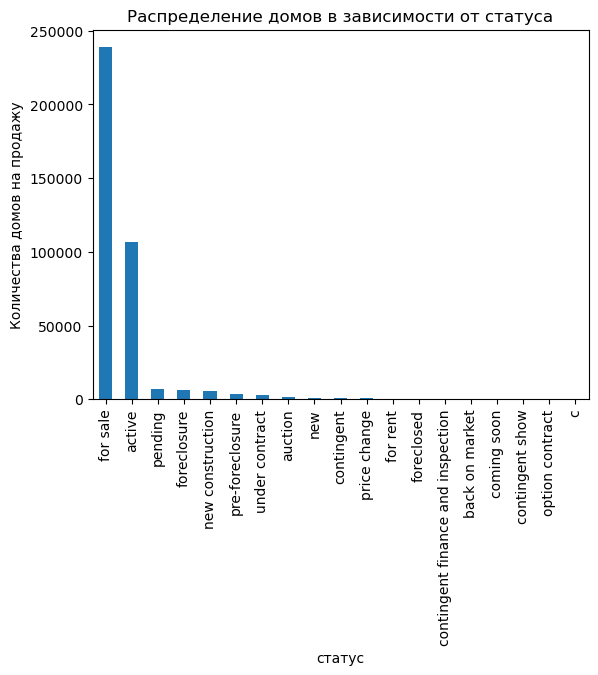

In [69]:
# оценка распределения количества домов на продажу по категориям статуса
ax = df_status['status'].value_counts() \
    .plot(kind='bar', title='Распределение домов в зависимости от статуса')

ax.set_xlabel('статус')
ax.set_ylabel('Количества домов на продажу')

 #### <span style="color:#32CD32"> Выводы:</span>
  - наибольшее количество продаваемых объектов имеют тип 'for sale'
  - необходимо оценить влияние цены на статус продаваемого объекта.

In [70]:
# визуализация распределения цен в категориях 'status'
fig = px.box(df_status.sort_values(by='target'), x="status", y="target")
fig.show()

Наибольший разброс по стоимости среди самых многоичесленных категорий. Также судя по их максимальным значениям стоимости, возможно это выбросы.

In [71]:
# визуализируем различия в стоимости, в зависимости от категории 'status':

data = df_status.dropna(subset=['target']).groupby('status')['target'].agg('mean').reset_index().sort_values(by='status')
px.scatter(data, x='status', y='target', size_max=30, size='target', color='target')

#### <span style="color:#32CD32"> Выводы:</span>
- очевидно, цена продаваемого объекта имеет связь с параметром статус;
- самая низкая стоимость у объектов под сдачу. Точнее указанная цена не является ценой объекта на продажу.

### <span style="color:#1E90FF"> Оценка параметра 'propertyType'</span>

In [72]:
# для удобства переименуем колонку 'propertyType' в 'type'

df_status = df_status.rename(columns={'propertyType' : 'type'})

In [73]:
# форматирование названий
df_status['type'] = df_status['type'].str.lower()

In [74]:
# перед внесением изменений сделаем копию датасета
df_type = df_status.copy()

In [75]:
# предварительное определение количества уникальных типов 
len(df_type['type'].unique())

1272

In [76]:
df_type['type'].value_counts().head(25)

single-family home               91364
single family                    61880
condo                            42365
single family home               31543
lot/land                         20503
townhouse                        18343
land                             10919
multi-family                      7894
condo/townhome/row home/co-op     7672
traditional                       5911
coop                              3264
multi family                      2771
high rise                         1823
ranch                             1780
detached, one story               1614
mobile/manufactured               1613
single detached, traditional      1581
contemporary                      1556
multi-family home                 1496
1 story                           1235
colonial                          1195
mobile / manufactured             1056
contemporary/modern               1000
2 stories                          911
apartment                          796
Name: type, dtype: int64

<span style="color:#32CD32"> Уникальных типов 1272, вероятно, что среди них много одинаковых, но имеющих разные обозначения. Имеет смысл их объединить.</span>

<span style="color:#1E90FF"> Перед группировкой наименований типов домов были проанализированы основные типы недвижимости на сайтах по продаже недвижимости: - www.realtor.com; - www.zillow.com; - silvarealtygroup.info</span>

In [77]:
# объединение типов продаваемой недвижимости
import re

df_type['type'] = df_type['type'].str.replace(r'\b.*\s*single\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*multi\b.*', 'multi family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*1 story\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*2 stories\b.*', 'multi family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*mobile\b.*', 'mobile')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*lot\b.*', 'land')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*condo\b.*', 'condo')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*one story\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*2 story\b.*', 'multi family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*two story\b.*', 'multi family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*ranch\b.*', 'farm')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*apartment\b.*', 'condo')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*farms\b.*', 'farm')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*farm\b.*', 'farm')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*farmhouse\b.*', 'farm')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*multiple\b.*', 'multi family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*garden home\b.*', 'bungalow')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*bungalow\b.*', 'bungalow')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*townhouse\b.*', 'townhouse')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*cooperative\b.*', 'coop')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*high rise\b.*', 'condo')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*traditional\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*contemporary\b.*', 'contemporary')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*transitional\b.*', 'transitional')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*mediterranean\b.*', 'mediterranean')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*other\b.*', 'other')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*condominium\b.*', 'condo')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*florida\b.*', 'florida')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*split-level\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*stories\b.*', 'multi family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*detached\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*cottage\b.*', 'cottage')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*cluster home\b.*', 'cluster home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*custom\b.*', 'custom')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*craftsman\b.*', 'custom')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*level\b.*', 'split level house')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*attached\b.*', 'townhouse')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*cluster home\b.*', 'townhouse')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*spanish\b.*', 'mediterranean')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*miscellaneous\b.*', 'other')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*penthouse\b.*', 'condo')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*loft\b.*', 'condo')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*federal\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*duplex\b.*', 'townhouse')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*fourplex\b.*', 'townhouse')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*multiplex\b.*', 'townhouse')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*a-frame\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*florida\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*mediterranean\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*victorian\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*tudor\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*cape cod\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*english\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*french\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*tuscan\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*co-op\b.*', 'coop')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*rancher\b.*', 'coop')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*european\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*georgian\b.*', 'single family home')
df_type['type'] = df_type['type'].str.replace(r'\b.*\s*modern\b.*', 'contemporary')
df_type.loc[(df_type['type'] == 'singlefamilyresidence'), 'type'] = 'single family home'

In [78]:
# количество типов недвижимости после обработки
len(df_type['type'].unique())

132

In [79]:
df_type['type'].value_counts().head(25)

single family home       201797
condo                     53868
land                      31445
townhouse                 18854
multi family home         15565
coop                       3871
mobile                     3470
contemporary               3123
farm                       2761
colonial                   1195
bungalow                    950
other                       707
transitional                595
custom                      372
split level house           215
                            124
residential (<1 acre)        95
key west                     72
cottage                      71
straight thru                52
unknown                      30
mid-rise                     27
elevated                     23
beaux arts                   22
coach/carriage               21
Name: type, dtype: int64

<span style="color:#32CD32"> Типов недвижимости стало меньше, но все равно еще очень много.</span>

In [80]:
# создание датасета из 15 первых категорий, отсортированных по значимому количеству 

a = dict(df_type['type'].value_counts().head(15))
a = a.keys()
filtred_a = df_type[df_type['type'].isin(a)]

In [81]:
# количество строк в полученном датасете
filtred_a.shape

(338788, 13)

In [82]:
# создание датасета из первых 15 категорий, отсортированных по количеству
df_type_filtred = filtred_a.reset_index(drop=True)
df_type_filtred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338788 entries, 0 to 338787
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   status     338788 non-null  object 
 1   type       338788 non-null  object 
 2   street     338786 non-null  object 
 3   baths      262351 non-null  object 
 4   homeFacts  338788 non-null  object 
 5   schools    338788 non-null  object 
 6   sqft       316813 non-null  object 
 7   zipcode    338788 non-null  object 
 8   beds       273428 non-null  object 
 9   state      338788 non-null  object 
 10  stories    217172 non-null  object 
 11  target     338788 non-null  float64
 12  pool       338788 non-null  int64  
dtypes: float64(1), int64(1), object(11)
memory usage: 33.6+ MB


In [83]:
# визуализируем различия в стоимости, в зависимости от категории 'status':

data = df_type_filtred.groupby('type')['target'].agg('mean').reset_index().sort_values(by='type')
px.scatter(data, x='type', y='target', size_max=20, size='target', color='target')

#### <span style="color:#32CD32"> Вывод:</span>
датасета состоящего из 15 первых категорий, отсортированных по количеству, будет достаточно. От оставшихся 117 имеет смысл отказаться, так как искажение типа продаваемой недвижимости может повлиять на итоговый результат. Тем более, 338837 строки полученного датасета, из 15 категорий составляет 90,5% от общего количества исходного датасета.
Дополнительно стоит отмемить, явную зависимость стоимости продаваемого объекта от его типа.

### <span style="color:#1E90FF"> Оценим влияние площади продаваемого объекта 'sqft' на его цену 'target' </span>

In [84]:
# копирование датасета перед внесением изменений
df_sqft = df_type_filtred.copy()

In [85]:
df_sqft['sqft'].head(10)

0          2900
1    1,947 sqft
2    3,000 sqft
3    6,457 sqft
4           NaN
5      897 sqft
6         1,507
7          3588
8         1,930
9    1,300 sqft
Name: sqft, dtype: object

<span style="color:#1E90FF"> Необходимо привести все значения в колонке 'sqft' к типу float </span>

In [86]:
# изменение типа переменной sqft
df_sqft['sqft'] = df_sqft['sqft'].str.replace(r'\D', '')
df_sqft['sqft'] =pd.to_numeric(df_sqft['sqft'])

In [87]:
# оценка количества пропусков в столбце
df_sqft['sqft'].isnull().sum()

22785

In [88]:
df_sqft['sqft'].describe()

count    3.160030e+05
mean     6.855998e+03
std      1.632614e+06
min      0.000000e+00
25%      1.247000e+03
50%      1.801000e+03
75%      2.593000e+03
max      7.959794e+08
Name: sqft, dtype: float64

<span style="color:#32CD32"> Присутствуют объекты с площадью 0, явно это ошибка. В тоже время, среди объектов недвижимости присутствуют категории mobile, что явно может соответствовать значениям площади около 6 квадратных футов </span>

In [89]:
# удаление из датасета объектов недвижимости с площадью ниже 5 квадратных футов
df_sqft = df_sqft[df_sqft.sqft > 5]

In [90]:
df_sqft[df_sqft['sqft'] > 8000000]

status                type            street    baths  \
56400   for sale  single family home     1723 Pulte St  2 Baths   
338195    active   multi family home  5382 S Dixie Hwy      NaN   

                                                homeFacts  \
56400   {'atAGlanceFacts': [{'factValue': '1901', 'fac...   
338195  {'atAGlanceFacts': [{'factValue': '2012', 'fac...   

                                                  schools         sqft  \
56400   [{'rating': ['4/10', '2/10', '1/10', '2/10', '...  795979430.0   
338195  [{'rating': ['5', '7', '7', 'NR', 'NR', 'NR'],...  456602479.0   

       zipcode    beds state stories    target  pool  
56400    45225  2 Beds    OH     1.0   27500.0     0  
338195   42740     NaN    KY     NaN  198000.0     0

<span style="color:#32CD32"> Присутствуют объекты с площадью 100 миллионов квадратных футов. Судя по описанию это явные ошибки. </span>

In [91]:
# удаление из датасета объектов недвижимости с площадью более 100 миллионов квадратных футов
df_sqft = df_sqft[df_sqft.sqft < 8000000]

In [92]:
df_sqft['sqft'].describe()

count    3.041080e+05
mean     3.005293e+03
std      2.714834e+04
min      6.000000e+00
25%      1.304000e+03
50%      1.849000e+03
75%      2.636000e+03
max      7.078574e+06
Name: sqft, dtype: float64

<span style="color:#1E90FF"> Замену пропусков необходимо выполнять с учетом типа недвижимости. 
Так как логично, что наибольшая блощадь будет у типа 'farm' и минимальная у типа 'mobile'. </span>

In [93]:
# замена пропусков на значения соответствующие типу объекта недвижимости
df_sqft['sqft'] = df_sqft['sqft'].fillna(df_sqft.groupby('type')['sqft'].transform('mean'))

In [94]:
# оценка количества пропусков в столбце
df_sqft['sqft'].isnull().sum()

0

In [95]:
df_sqft['sqft'].describe()

count    3.041080e+05
mean     3.005293e+03
std      2.714834e+04
min      6.000000e+00
25%      1.304000e+03
50%      1.849000e+03
75%      2.636000e+03
max      7.078574e+06
Name: sqft, dtype: float64

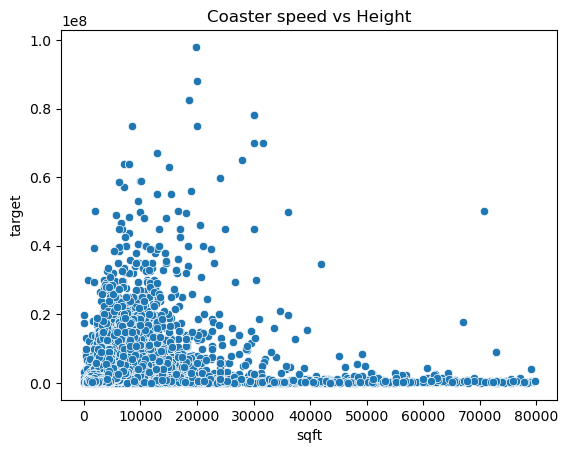

In [96]:
# распределение стоимости объектов недвижимости в зависимости от площади
ax = sns.scatterplot(x = 'sqft',
        y = 'target',
        data = df_sqft[df_sqft['sqft'] < 80000])
ax.set_title('Coaster speed vs Height')
plt.show()

До определенного значение площади стоимость объекта недвижимости растет. Затем появляется большой "хвост" с высокой площадью и относительно низкой стоимостью. 

In [97]:
df_sqft = df_sqft.reset_index(drop=True)

#### <span style="color:#32CD32"> Выводы:</span>
- связь между площадью и стоимостью выглядит прямопропорциональной, но однозначного тренда нет. Значит площадь не главный фактор, влияющий на цену.

### <span style="color:#1E90FF"> Рассмотрим параметр 'homeFacts' </span>

In [98]:
# копирование датасета перед внесением изменений
df_home = df_sqft.copy()

In [99]:
df_home['homeFacts'].value_counts()

{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '-- sqft lot', 'factLabel': 'lotsize'}, {'factValue': '', 'factLabel': 'Price/sqft'}]}                                               133
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '', 'factLabel': 'lotsize'}, {'factValue': '$142/sqft', 'factLabel': 'Price/sqft'}]}                                                 107
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'fact

<span style="color:#1E90FF"> В параметре 'homeFacts' присутствует инфомрация о годе постройки задния. Для этой характеристики будет сделана новая колонка </span>

In [100]:
# создание колонки с годом постройки 
df_home['year build'] = df_home['homeFacts'].str.findall(r'\d{4}')

In [101]:
# преобразование полученной колонки в числовую переменную
df_home['year build'] = df_home['year build'].str[0]
df_home['year build'] =pd.to_numeric(df_home['year build'], downcast='integer')

In [102]:
# после определения года строения появились объекты с годом постройки менее 1750 года 
df_home[df_home['year build'] < 1750].shape

(185, 14)

In [103]:
# после определения года строения появились объекты с годом постройки  более 2021 года. 
df_home[df_home['year build'] > 2021].shape

(728, 14)

<span style="color:#32CD32"> так как количество домов с сомнительным годом постройки относительно общего датасета незначительно, то они будут удалены </span>

In [104]:
df_home = df_home[df_home['year build'] > 1750]
df_home = df_home[df_home['year build'] < 2021]

In [105]:
df_home = df_home.reset_index(drop=True)

In [106]:
# удаление столбца, так как из него получена основная информация о строении
df_home.drop(['homeFacts'], axis=1, inplace=True)

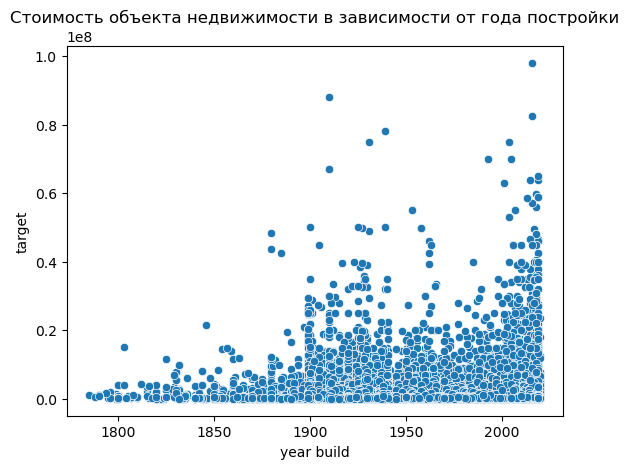

In [107]:
ax = sns.scatterplot(x = 'year build',
        y = 'target',
        data = df_home)
ax.set_title('Стоимость объекта недвижимости в зависимости от года постройки')
plt.show()

In [108]:
df_home = df_home.reset_index(drop=True)

#### <span style="color:#32CD32"> Выводы:</span>
- создан новый столбец с годом постройки объекта недвижимости;
- удален столбец 'homeFacts', так как в нем дополнительная информация, которая дублируется частично другими колонками в датафрейме;
- из графика видно, чем новее объект недвижимости, как правило и выше его стоимость.

### <span style="color:#1E90FF"> Анализ колонки 'school' </span>

In [109]:
# копирование датасета перед внесением изменений
df_school = df_home.copy()

In [110]:
df_school['schools'].value_counts()

[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                           2230
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}]     151
[{'rating': ['5/10', '3/10', '5/10'], 'data': {'Distance': ['9.71mi', '8.92mi', '1.56mi'], 'Grades': ['5-8', '9-12', 'K-4']}, 'name': ['Cheatham Middle School', 'Cheatham Co Central', 'West Cheatham Elementary School']}]                    117
[{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']}, 'name': ['Horizon Middle School', 'Desert Hills Elementary School', 'Horizon High School']}]                     103
[{'rating': ['10/10', '2

In [111]:
# создание колонок с рейтингом школы
df_school['school_r_10'] = df_school['schools'].str.findall('10/10').str[0]
df_school['school_r_9'] = df_school['schools'].str.findall('9/10').str[0]
df_school['school_r_8'] = df_school['schools'].str.findall('8/10').str[0]
df_school['school_r_7'] = df_school['schools'].str.findall('7/10').str[0]
df_school['school_r_6'] = df_school['schools'].str.findall('6/10').str[0]
df_school['school_r_5'] = df_school['schools'].str.findall('5/10').str[0]
df_school['school_r_4'] = df_school['schools'].str.findall('4/10').str[0]
df_school['school_r_3'] = df_school['schools'].str.findall('3/10').str[0]
df_school['school_r_2'] = df_school['schools'].str.findall('2/10').str[0]
df_school['school_r_1'] = df_school['schools'].str.findall('1/10').str[0]

In [112]:
# замена пропусков и значений рейтинга на 0 и 1
df_school['school_r_10'] = np.where(df_school['school_r_10'].isnull(), 0, 1)
df_school['school_r_9'] = np.where(df_school['school_r_9'].isnull(), 0, 1)
df_school['school_r_8'] = np.where(df_school['school_r_8'].isnull(), 0, 1)
df_school['school_r_7'] = np.where(df_school['school_r_7'].isnull(), 0, 1)
df_school['school_r_6'] = np.where(df_school['school_r_6'].isnull(), 0, 1)
df_school['school_r_5'] = np.where(df_school['school_r_5'].isnull(), 0, 1)
df_school['school_r_4'] = np.where(df_school['school_r_4'].isnull(), 0, 1)
df_school['school_r_3'] = np.where(df_school['school_r_3'].isnull(), 0, 1)
df_school['school_r_2'] = np.where(df_school['school_r_2'].isnull(), 0, 1)
df_school['school_r_1'] = np.where(df_school['school_r_1'].isnull(), 0, 1)

In [113]:
# средняя стомость недвижимости, рядом с которой находится школа с рейтингом 10
df_school.groupby('school_r_10')['target'].agg('mean')

school_r_10
0    5.596980e+05
1    1.351957e+06
Name: target, dtype: float64

In [114]:
# средняя стомость недвижимости, рядом с которой находится школа с рейтингом 2
df_school.groupby('school_r_2')['target'].agg('mean')

school_r_2
0    710783.763750
1    409622.173252
Name: target, dtype: float64

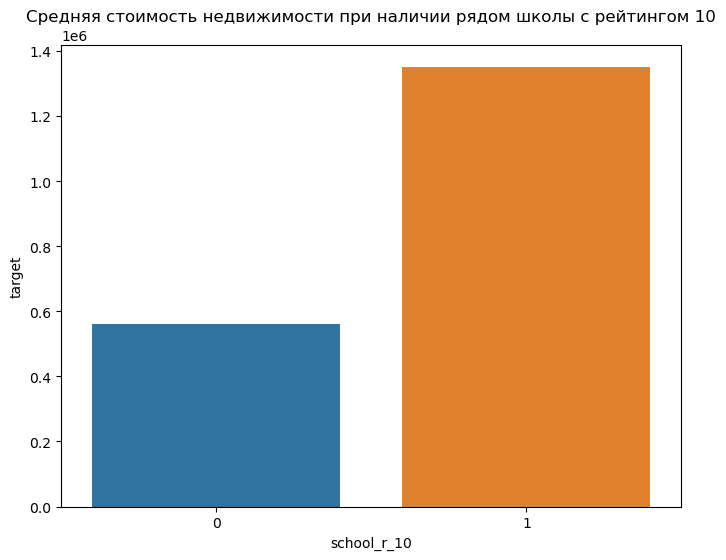

In [115]:
# средняя цена продаваемого объекта в зависимости от наличия или отсутствия рядом школы с рейтингом 10
fig = plt.figure(figsize=(8, 6))
data = df_school.groupby('school_r_10')['target'].agg('mean').reset_index().sort_values(by='school_r_10')
barplot = sns.barplot(
    data = data,
    x = 'school_r_10',
    y = 'target'
)
barplot.set_title('Средняя стоимость недвижимости при наличии рядом школы с рейтингом 10')
plt.show()

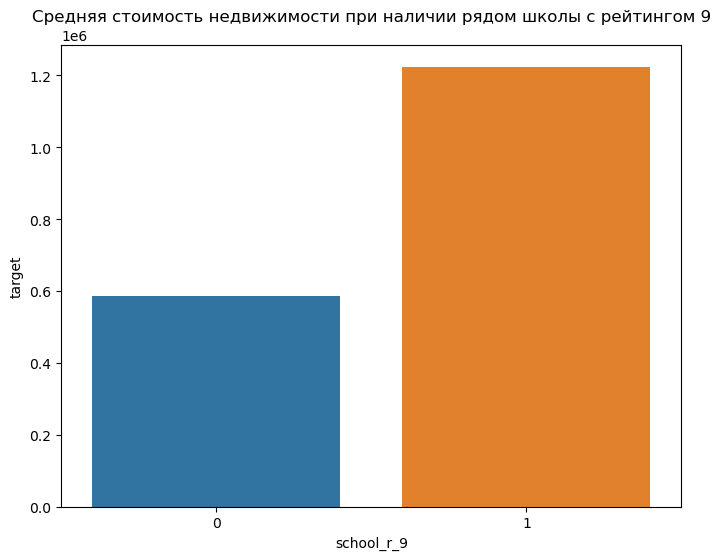

In [116]:
# средняя цена продаваемого объекта в зависимости от наличия или отсутствия рядом школы с рейтингом 9
data = df_school.groupby('school_r_9')['target'].agg('mean').reset_index().sort_values(by='school_r_9')


fig = plt.figure(figsize=(8, 6))
data = df_school.groupby('school_r_9')['target'].agg('mean').reset_index().sort_values(by='school_r_9')
barplot = sns.barplot(
    data = data,
    x = 'school_r_9',
    y = 'target'
)
barplot.set_title('Средняя стоимость недвижимости при наличии рядом школы c рейтингом 9')
plt.show()

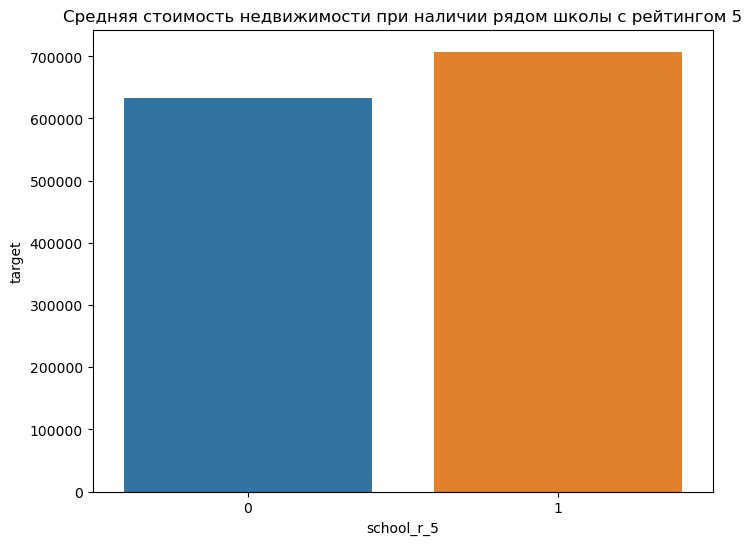

In [117]:
# средняя цена продаваемого объекта в зависимости от наличия или отсутствия рядом школы с рейтингом 5
data = df_school.groupby('school_r_5')['target'].agg('mean').reset_index().sort_values(by='school_r_5')

fig = plt.figure(figsize=(8, 6))
data = df_school.groupby('school_r_5')['target'].agg('mean').reset_index().sort_values(by='school_r_5')
barplot = sns.barplot(
    data = data,
    x = 'school_r_5',
    y = 'target'
)
barplot.set_title('Средняя стоимость недвижимости при наличии рядом школы c рейтингом 5')
plt.show()

In [118]:
# удалени колонки 'schools', так как необходимая информация из нее извлечена
df_school = df_school.drop(['schools'], axis=1)
df_school = df_school.reset_index(drop=True)

#### <span style="color:#32CD32"> Выводы:</span>
- у объектов недвижимости, рядом с которыми находится школа с высоким рейтингом, цена выше, чем если рядом находится школа с низким рейтингом
- исходная колонка 'schools' удалена

## <span style="color:#1E90FF"> Анализ колонки 'beds' </span>

In [119]:
# копирование датасета перед внесением изменений
df_beds = df_school.copy()

In [120]:
df_beds['beds'].value_counts()

3 Beds                  47366
4 Beds                  30219
3                       29364
2 Beds                  24289
4                       18688
                        ...  
33 Beds                     1
17 bd                       1
53 Beds                     1
27.0                        1
# Bedrooms 1st Floor        1
Name: beds, Length: 136, dtype: int64

In [121]:
# форматирование регистра шрифта
df_beds['beds'] = df_beds['beds'].str.lower()

In [122]:
# выделение из текстовой части только количество крвоатей
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*\s*bd\b.*', '')

df_beds['beds'] = df_beds['beds'].str.replace('1.0', '1')
df_beds['beds'] = df_beds['beds'].str.replace('2.0', '2')
df_beds['beds'] = df_beds['beds'].str.replace('3.0', '3')
df_beds['beds'] = df_beds['beds'].str.replace('4.0', '4')
df_beds['beds'] = df_beds['beds'].str.replace('5.0', '5')
df_beds['beds'] = df_beds['beds'].str.replace('6.0', '6')
df_beds['beds'] = df_beds['beds'].str.replace('7.0', '7')
df_beds['beds'] = df_beds['beds'].str.replace('8.0', '8')
df_beds['beds'] = df_beds['beds'].str.replace('9.0', '9')
df_beds['beds'] = df_beds['beds'].str.replace('-- ', '0')
df_beds['beds'] = df_beds['beds'].str.replace('0.0', '0')

df_beds['beds'] = df_beds['beds'].str.replace('1 beds', '1')
df_beds['beds'] = df_beds['beds'].str.replace('2 beds', '2')
df_beds['beds'] = df_beds['beds'].str.replace('3 beds', '3')
df_beds['beds'] = df_beds['beds'].str.replace('4 beds', '4')
df_beds['beds'] = df_beds['beds'].str.replace('5 beds', '5')
df_beds['beds'] = df_beds['beds'].str.replace('6 beds', '6')
df_beds['beds'] = df_beds['beds'].str.replace('7 beds', '7')
df_beds['beds'] = df_beds['beds'].str.replace('8 beds', '8')
df_beds['beds'] = df_beds['beds'].str.replace('9 beds', '9')
df_beds['beds'] = df_beds['beds'].str.replace('10 beds', '9')

df_beds['beds'] = df_beds['beds'].str.replace('baths', '3')
df_beds['beds'] = df_beds['beds'].str.replace('bath', '3')
df_beds['beds'] = df_beds['beds'].str.replace('beds', '')

df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*acres\b.*', '2')
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*acre\b.*', '0')
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*sqft\b.*', '2')
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*2 bedrooms\b.*', '2')
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*3 bedrooms\b.*', '3')
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*3 or more\b.*', '3')
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*based\b.*', '2')
df_beds['beds'] = df_beds['beds'].str.replace(r'\b.*bedrooms 1st\b.*', '0')
df_beds['beds'] = df_beds['beds'].str.replace('# 2', '0')
df_beds['beds'] = df_beds['beds'].str.replace('1-2', '1')
df_beds['beds'] = df_beds['beds'].str.replace('#00', '0')

In [123]:
# замена знаков с нулями на 0
df_beds['beds'] = df_beds['beds'].str.replace('#00', '0')
df_beds['beds'] = df_beds['beds'].str.replace(' ', '0')

In [124]:
# замена знаков с 0 на 0
df_beds['beds'] = df_beds['beds'].str.replace('#00', '0')

In [125]:
# преобразование строки в число
df_beds['beds'] = pd.to_numeric(df_beds['beds'])

In [126]:
# визуализация связи количества спальных комнат от стоимости жилья
data = df_beds.groupby('beds')['target'].agg('mean').reset_index().sort_values(by='beds')
px.scatter(data, x='beds', y='target', size_max=20, size='target', color='target')

In [127]:
# количество кроватей больше 140 явно выбросы. 
# удаление выбросов
df_beds = df_beds[df_beds.beds < 140]

In [128]:
df_beds = df_beds.reset_index(drop=True)

In [129]:
# замена пропусков на значения соответствующие типу объекта недвижимости
df_beds['beds'] = df_beds['beds'].fillna(round(df_beds.groupby('type')['beds'].transform('mean'),1))

In [130]:
# округление в меньшую сторону
df_beds['beds'] = df_beds['beds'].apply(np.ceil)

In [131]:
# визуализация связи количества спальных комнат от стоимости жилья
data = df_beds.groupby('beds')['target'].agg('mean').reset_index().sort_values(by='beds')
px.scatter(data, x='beds', y='target', size_max=20, size='target', color='target')

#### <span style="color:#32CD32"> Выводы:</span>
- количество спален связано со стоимостью объекта недвижимости. В то же время, очевидно, что этот параметр должен коррелировать с площадью.

## <span style="color:#1E90FF"> Анализ колонки 'baths' </span>

In [132]:
# копирование датасета перед внесением изменений
df_baths = df_beds.copy()

In [133]:
df_baths['baths'].value_counts().head(20)

2 Baths      45725
3 Baths      32386
2            18998
2.0          15808
4 Baths      13680
3.0          10295
3             9307
2.5           6753
1             6226
1.0           5692
5 Baths       5113
4.0           4322
4             3332
3.5           2979
6 Baths       2468
1.5           1775
5.0           1489
2.5 Baths     1219
5             1169
7 Baths       1161
Name: baths, dtype: int64

In [134]:
# форматирование регистра
df_baths['baths'] = df_baths['baths'].str.lower()

In [135]:
# замена символов для дальнейшего группирования по количеству ванн
df_baths['baths'] = df_baths['baths'].str.replace(' baths', '')
df_baths['baths'] = df_baths['baths'].str.replace(' ba', '')
df_baths['baths'] = df_baths['baths'].str.replace('bathrooms: ', '')
df_baths['baths'] = df_baths['baths'].str.replace('.0', '')
df_baths['baths'] = df_baths['baths'].str.replace('.5', '')
df_baths['baths'] = df_baths['baths'].str.replace('+', '')
df_baths['baths'] = df_baths['baths'].str.replace('~', '0')
df_baths['baths'] = df_baths['baths'].str.replace('--', '0')
df_baths['baths'] = df_baths['baths'].str.replace('0.', '0')
df_baths['baths'] = df_baths['baths'].str.replace(',', '.')
df_baths['baths'] = df_baths['baths'].str.replace('0/', '0')
df_baths['baths'] = df_baths['baths'].str.replace('1-2', '1')

In [136]:
# удаление строк, содержащих неоднозначную информацию
df_baths = df_baths[df_baths.baths != 'semimod']
df_baths = df_baths[df_baths.baths != '3-1 / 2-2']
df_baths = df_baths[df_baths.baths != '116 / 116 / 116']
df_baths = df_baths[df_baths.baths != '1 / 1 / 1']
df_baths = df_baths[df_baths.baths != '2-1 / 2-1 / 1-1 / 1-1']
df_baths = df_baths[df_baths.baths != '1 / 1 / 1 / 1']
df_baths = df_baths[df_baths.baths != 'sq. ft. ']

In [137]:
# замена строки на число
df_baths['baths'] = pd.to_numeric(df_baths['baths'], errors = 'coerce')

In [138]:
# округление в меньшую сторону
df_baths['baths'] = df_baths['baths'].apply(np.ceil)

In [139]:
# количество пропусков
df_baths['baths'].isnull().sum()

15315

In [140]:
# замена пропусков на значения соответствующие типу объекта недвижимости
df_baths['baths'] = df_baths['baths'].fillna(round(df_baths.groupby('type')['baths'].transform('mean'),1))

In [141]:
# визуализация связи количества ванных комнат от стоимости жилья
data = df_baths.groupby('baths')['target'].agg('mean').reset_index().sort_values(by='baths')
px.scatter(data, x='baths', y='target', size_max=20, size='target', color='target')

In [142]:
# проверка типов объектов недвижимости с нулевым количеством ванных комнат
df_baths[(df_baths['baths'] == 0) & (df_baths['type'] == 'mobile')]

status    type           street  baths     sqft zipcode  beds state  \
33665  for sale  mobile   912 Murcott St    0.0    712.0   33803   0.0    FL   
90923    active  mobile  1877 Route 20 S    0.0  16500.0   14781   0.0    NY   

      stories   target  ...  school_r_10  school_r_9  school_r_8  school_r_7  \
33665     0.0   6500.0  ...            0           0           0           0   
90923  1.0000  42500.0  ...            0           0           0           0   

       school_r_6  school_r_5  school_r_4  school_r_3  school_r_2  school_r_1  
33665           0           1           0           1           1           0  
90923           0           0           0           0           0           0  

[2 rows x 22 columns]

<span style="color:#32CD32"> Среди объектов недвижимсоти с нулевым количеством ванных комнат 
есть две строки mobile, но у них очень высокая площадь. Эти строки можно удалить.
Нули необходимо заменить на среднее в соответствии с типом объекта недвижимости </span>

In [143]:
# удаление 2-х строк, полученных выше
df_baths = df_baths.drop(index = 33665)
df_baths = df_baths.drop(index = 90923)

In [144]:
# замена нулей на nan
df_baths['baths'] = df_baths['baths'].replace(0, np.nan)

In [145]:
# количество пропусков
df_baths['baths'].isnull().sum()

916

In [146]:
#замена пропусков на значения соответствующие типу объекта недвижимости
df_baths['baths'] = df_baths['baths'].fillna(round(df_baths.groupby('type')['baths'].transform('mean'),1))

In [147]:
# визуализация связи количества ванных комнат от стоимости жилья
data = df_baths.groupby('baths')['target'].agg('mean').reset_index().sort_values(by='baths')
px.scatter(data, x='baths', y='target', size_max=20, size='target', color='target')

#### <span style="color:#32CD32"> Выводы:</span>
- количество ванных комнат связано со стоимостью объекта недвижимости. В то же время, очевидно, что этот параметр должен коррелировать с площадью.

## <span style="color:#1E90FF"> Анализ колонки 'zipcode' </span>

<span style="color:#1E90FF"> Расположение дома - адрес 'street' учтено в почтовом коде 'zipcode'. Поэтому колонка 'street' будет удалена, а колонка 'zipcode' останется.  Также колонка 'stories' - это количество этажей, которое учтено в общей площади. Также согласно форумам о недвижимости кардинального отличия в стоимости домов в зависимости от этажей нет. Эта колонка также будет удалена.</span>

In [148]:
# копирование датасета перед внесением изменений

df_zipcode = df_baths.copy()
df_zipcode = df_zipcode.reset_index(drop=True)

In [149]:
df_zipcode = df_zipcode.drop(['street', 'stories'], axis=1)

In [150]:
df_zipcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221921 entries, 0 to 221920
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   status       221921 non-null  object 
 1   type         221921 non-null  object 
 2   baths        221921 non-null  float64
 3   sqft         221921 non-null  float64
 4   zipcode      221921 non-null  object 
 5   beds         221921 non-null  float64
 6   state        221921 non-null  object 
 7   target       221921 non-null  float64
 8   pool         221921 non-null  int64  
 9   year build   221921 non-null  float64
 10  school_r_10  221921 non-null  int64  
 11  school_r_9   221921 non-null  int64  
 12  school_r_8   221921 non-null  int64  
 13  school_r_7   221921 non-null  int64  
 14  school_r_6   221921 non-null  int64  
 15  school_r_5   221921 non-null  int64  
 16  school_r_4   221921 non-null  int64  
 17  school_r_3   221921 non-null  int64  
 18  school_r_2   221921 non-

In [151]:
# преобразование строки в число
df_zipcode['zipcode'] = pd.to_numeric(df_zipcode['zipcode'], errors = 'coerce')

In [152]:
# зипкод состоит из 5 цифр
# определение количества строк с зипкодом, состоящим из большего количества цифр
df_zipcode[df_zipcode['zipcode'] > 99999]

Empty DataFrame
Columns: [status, type, baths, sqft, zipcode, beds, state, target, pool, year build, school_r_10, school_r_9, school_r_8, school_r_7, school_r_6, school_r_5, school_r_4, school_r_3, school_r_2, school_r_1]
Index: []

In [153]:
# зипкод состоит из 5 цифр
# определение количества строк с зипкодом, состоящим из меньшего количества цифр
df_zipcode[df_zipcode['zipcode'] < 9999]

status                type  baths    sqft  zipcode  beds state  \
41        active  single family home    2.0  2272.0   8701.0   2.0    NJ   
47      for sale               condo    2.0  1060.0   2127.0   2.0    MA   
123       active  single family home    4.0  3464.0   5445.0   4.0    VT   
205       active  single family home    1.0  1834.0   5488.0   3.0    VT   
230     for sale               condo    4.0  3463.0   2108.0   3.0    MA   
...          ...                 ...    ...     ...      ...   ...   ...   
221709    active  single family home    1.0  1120.0   5491.0   2.0    VT   
221726    active  single family home    3.0  4100.0   7004.0   4.0    NJ   
221831  for sale               condo    2.0  1750.0   2118.0   3.0    MA   
221842    active               condo    3.0  3170.0   8701.0   5.0    NJ   
221870  for sale               condo    2.3   801.0   2131.0   2.0    MA   

           target  pool  year build  school_r_10  school_r_9  school_r_8  \
41       269000.0     0      1999.0            0           0           0   
47       916900.0     0      2019.0            0           0           0   
123      743900.0     0      2019.0            0           0           0   
205      209900.0     0      2003.0            0           0           0   
230     3995000.0     0      1930.0            0           0           0   
...           ...   ...         ...          ...         ...         ...   
221709   259000.0     0      1888.0            0           0           0   
221726   819999.0     0      2006.0            0           0           0   
221831  1450000.0     0      1899.0            0           0           0   
221842   569900.0     0      2020.0            0           0           0   
221870   399000.0     0      1899.0            0           0           0   

        school_r_7  school_r_6  school_r_5  school_r_4  school_r_3  \
41               0           0           0           0           0   
47               0           0           0           0           0   
123              0           0           0           0           0   
205              0           0           0           0           0   
230              0           0           0           0           0   
...            ...         ...         ...         ...         ...   
221709           0           0           0           0           0   
221726           0           0           0           0           0   
221831           0           0           0           0           0   
221842           0           0           0           0           0   
221870           0           0           0           0           0   

        school_r_2  school_r_1  
41               0           0  
47               0           0  
123              0           0  
205              0           0  
230              0           1  
...            ...         ...  
221709           0           0  
221726           0           0  
221831           0           1  
221842           0           0  
221870           0           0  

[1596 rows x 20 columns]

<span style="color:#1E90FF"> Так как ошибочным значениям зипкода адекватную замену практически не подобрать, то эти строки будут удалены </span>

In [154]:
# удаление строк, содержащих зипкод с количеством цифр менее 5
df_zipcode = df_zipcode[df_zipcode['zipcode'] > 9999]
df_zipcode = df_zipcode.reset_index(drop=True)

#### <span style="color:#32CD32"> Выводы:</span>
- признак 'zipcode' содержит в себе расположение объекта недвижимости, включая район.
- были удалены все строки, которые содержали в 'zipcode' менее 5 и более 5 цифр.

<span style="color:#1E90FF"> Подготовка датасета для моделей </span>

In [155]:
# датасет для обучения моделей
data = df_zipcode.copy()

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220254 entries, 0 to 220253
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   status       220254 non-null  object 
 1   type         220254 non-null  object 
 2   baths        220254 non-null  float64
 3   sqft         220254 non-null  float64
 4   zipcode      220254 non-null  float64
 5   beds         220254 non-null  float64
 6   state        220254 non-null  object 
 7   target       220254 non-null  float64
 8   pool         220254 non-null  int64  
 9   year build   220254 non-null  float64
 10  school_r_10  220254 non-null  int64  
 11  school_r_9   220254 non-null  int64  
 12  school_r_8   220254 non-null  int64  
 13  school_r_7   220254 non-null  int64  
 14  school_r_6   220254 non-null  int64  
 15  school_r_5   220254 non-null  int64  
 16  school_r_4   220254 non-null  int64  
 17  school_r_3   220254 non-null  int64  
 18  school_r_2   220254 non-

In [157]:
# кодирование строковых данных
status = pd.get_dummies(data['status'])
type_h = pd.get_dummies(data['type'])

In [158]:
# создание датасета с закодированными колонками
data_1 = pd.concat([status, type_h, data], axis=1)

In [159]:
# удаление исходных колонок, которые были закодированы
data_1 = data_1.drop(['status', 'state', 'type'], axis=1).reset_index(drop=True) 

#### <span style="color:#1E90FF"> Оценка корреляции переменных </span>

<Axes: >

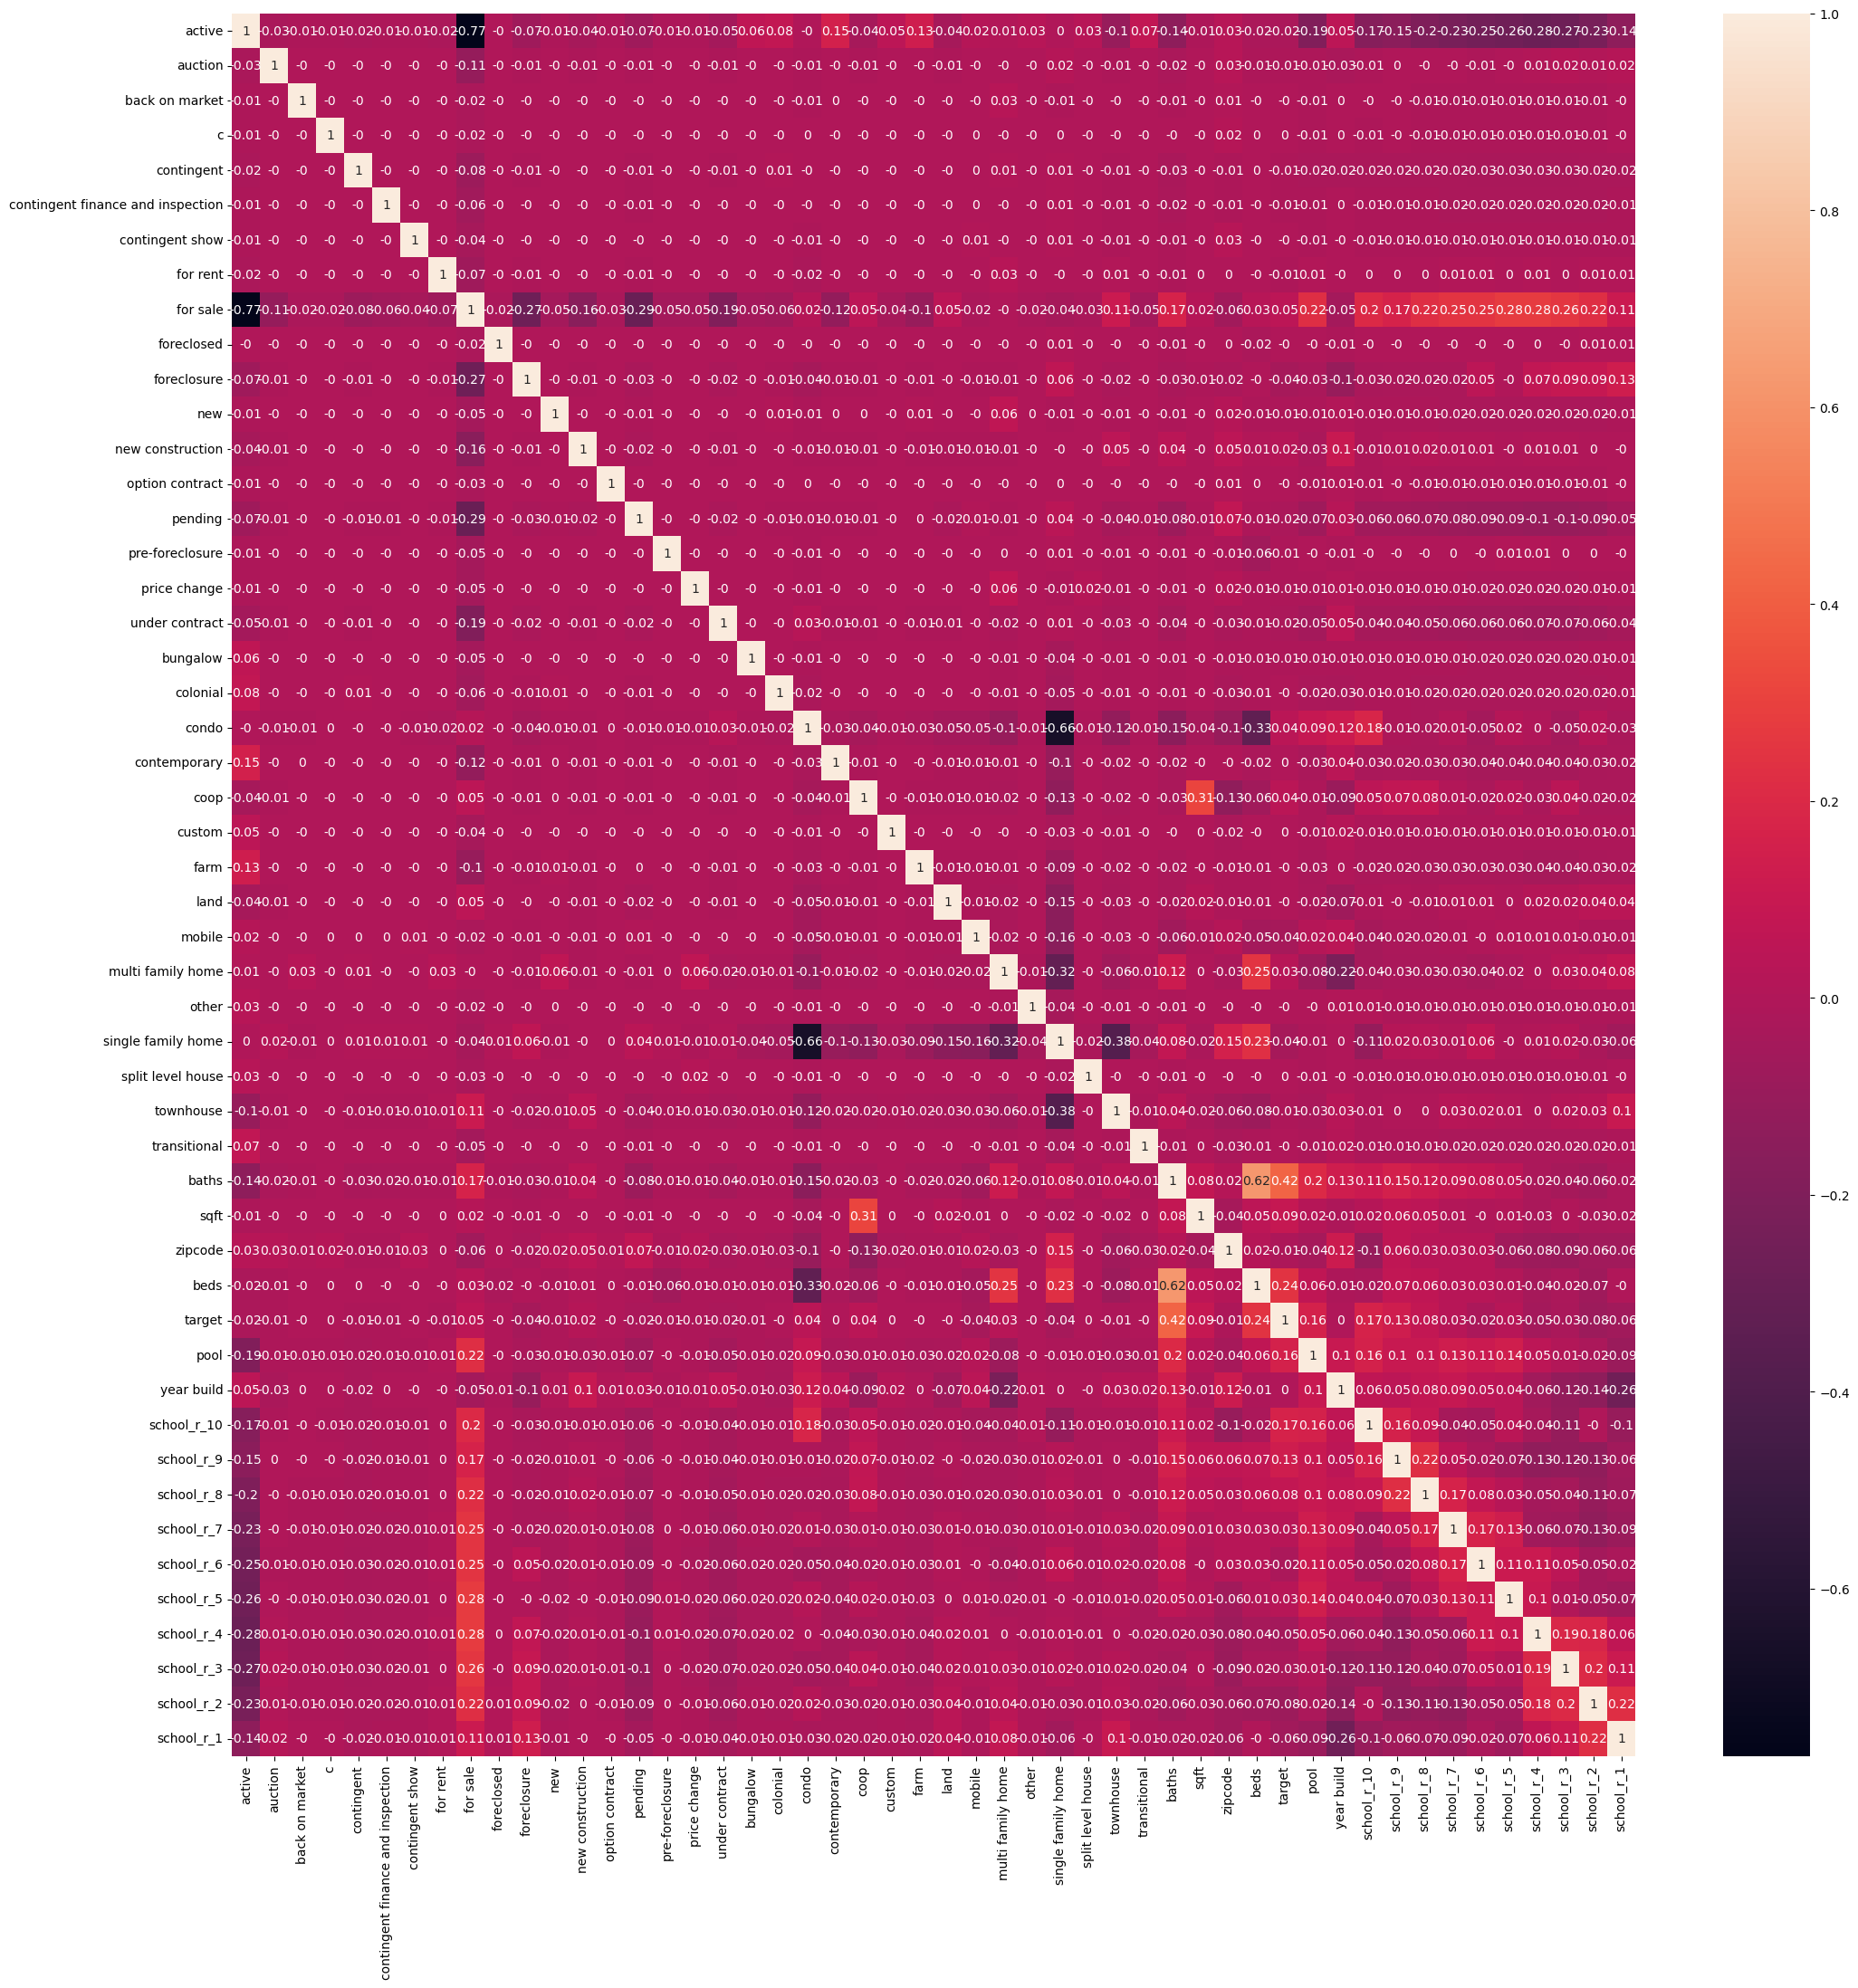

In [160]:
# тепловая карта корреляционной матрицы
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(data_1.corr().round(decimals=2), annot=True)

<span style="color:#32CD32"> В полученной матрице много признаков с практически нулевой корреляцией с разными параметрами. Эти колонки будут удалены  </span>

In [161]:
# очистка датасета от колонок, которые не влияют на результат
data_cor = data_1.drop(['back on market', 'c', 'contingent', 'contingent finance and inspection',
                       'for rent', 'foreclosed', 'new', 'option contract', 'pending', 'colonial',
                       'contemporary', 'custom', 'farm', 'land', 'other', 'split level house',
                       'contingent show', 'pre-foreclosure', 'price change', 'bungalow', 'transitional', 'auction',
                       'active', 'for sale', 'school_r_1', 'new construction', 'under contract'], axis=1)

<Axes: >

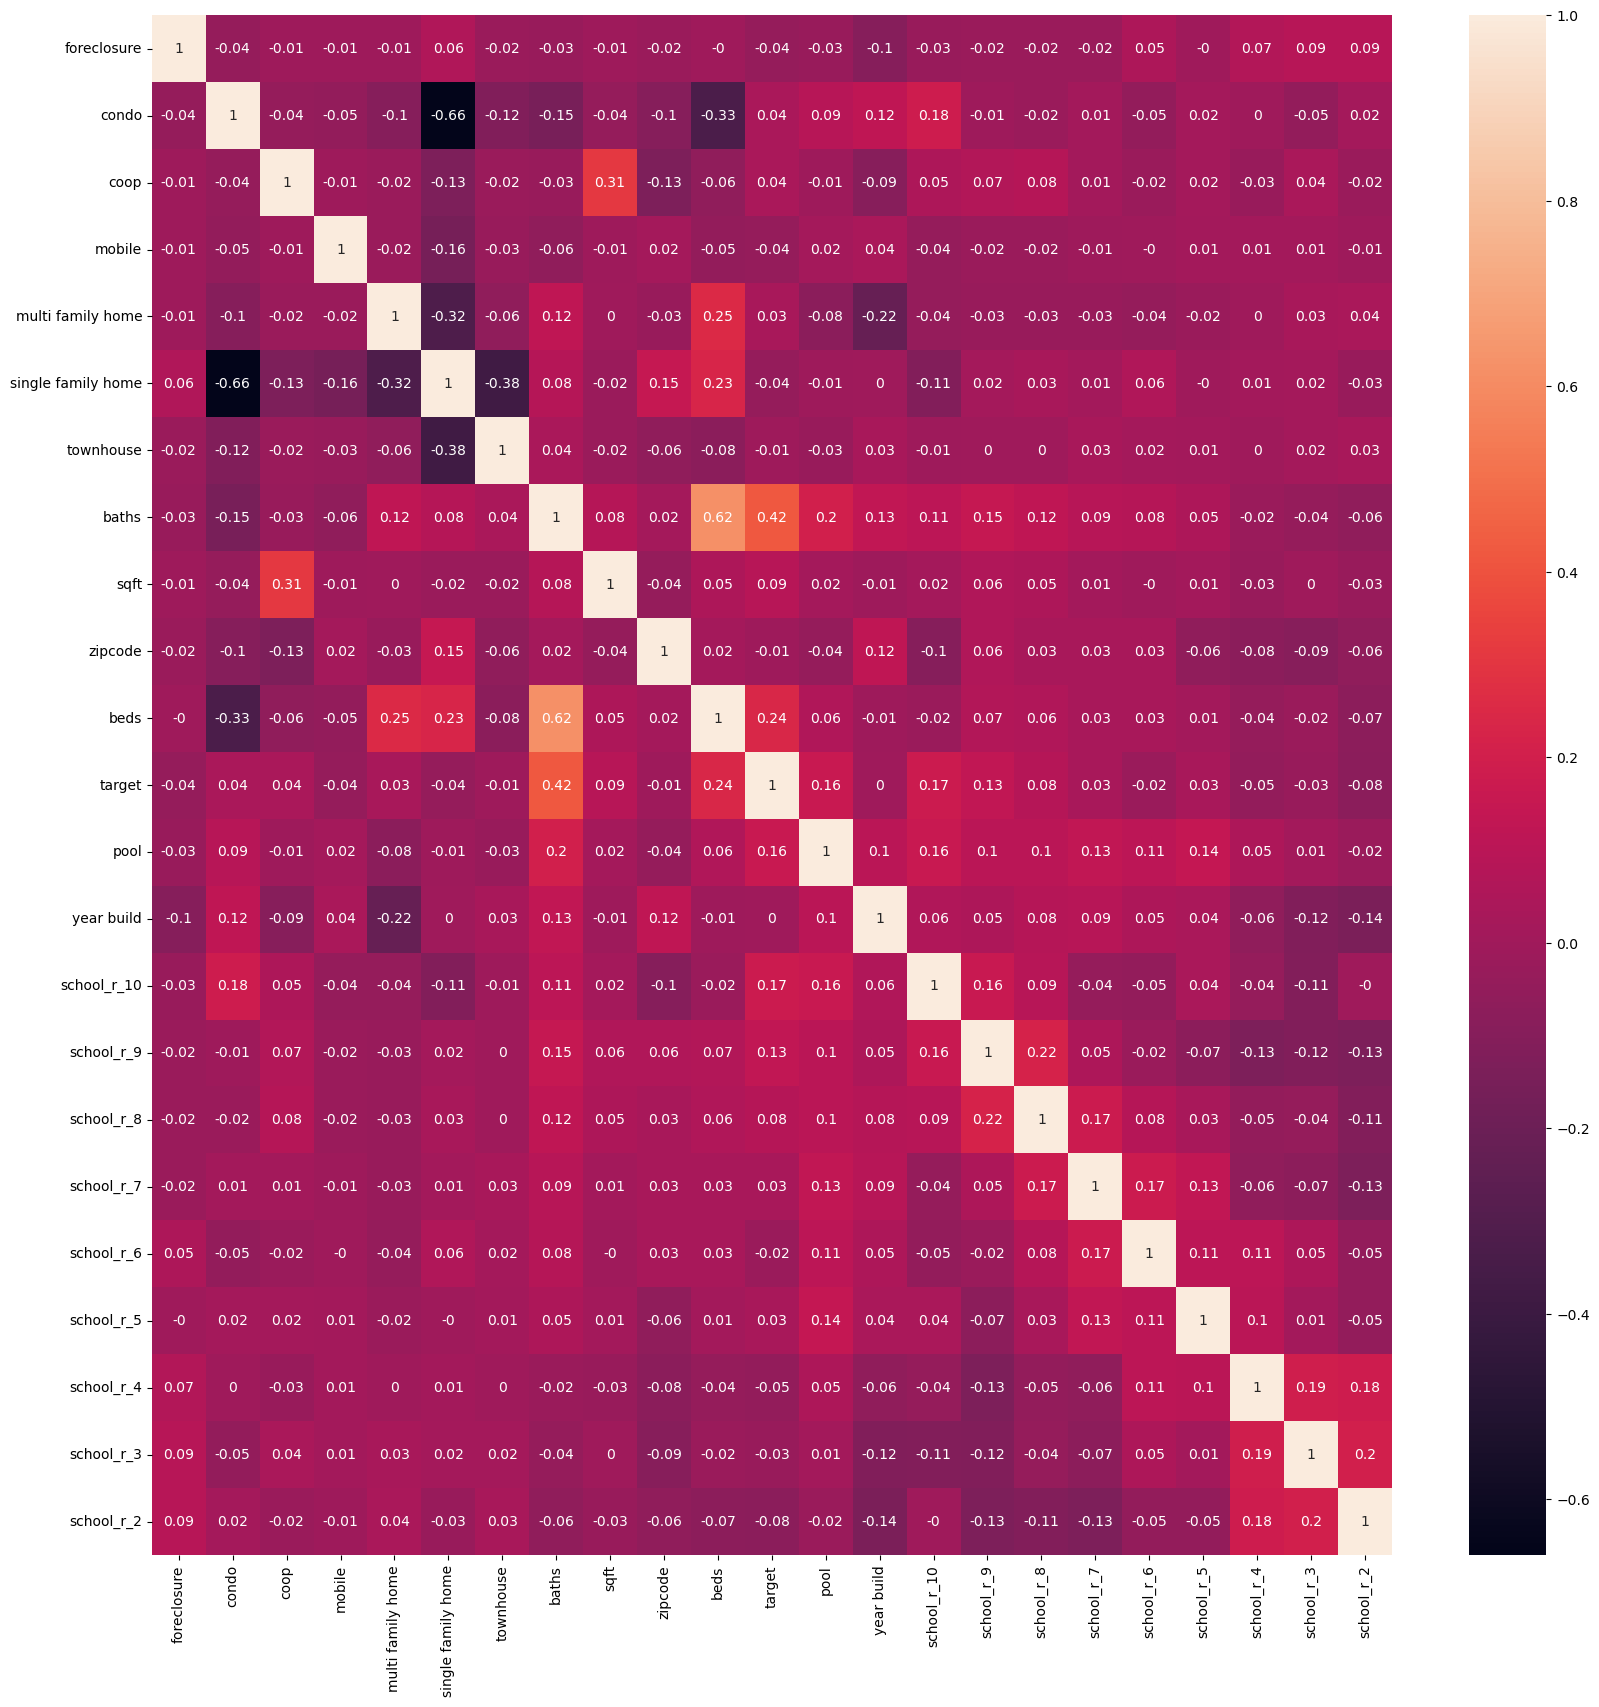

In [162]:
# тепловая карта корреляционной матрицы
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data_cor.corr().round(decimals=2), annot=True)

#### <span style="color:#32CD32"> Вывод: среди признаков оставлены те, у которых нулевая корреляция, так как эти признаки отмечаются на сайтах по продаже. </span>

## <span style="color:#1E90FF"> Обучение моделей на обработанных данных  </span>

In [163]:
# подготовка датасета
X = data_cor.drop(['target'], axis=1)
y = data_cor.target.values

In [164]:
# разделение датасета 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [165]:
# функция для обучения моделей

df_models = pd.DataFrame(data=None, columns=['Algorithm', 'r2_train', 'r2_test'])

make_model(X_train, X_test, y_train, y_test, LinearRegression(), 'LinearRegression')
make_model(X_train, X_test, y_train, y_test, Ridge(), 'Ridge')
make_model(X_train, X_test, y_train, y_test, Lasso(), 'Lasso')
make_model(X_train, X_test, y_train, y_test, ElasticNet(), 'ElasticNet')
make_model(X_train, X_test, y_train, y_test, CatBoostRegressor(), 'CatBoostRegression')
make_model(X_train, X_test, y_train, y_test, GradientBoostingRegressor(), 'GradientBoosting')
make_model(X_train, X_test, y_train, y_test, RandomForestRegressor(), 'RandomForest')
make_model(X_train, X_test, y_train, y_test, XGBRegressor(), 'XGBoost')

Learning rate set to 0.092694
0:	learn: 1637300.8443897	total: 5.08ms	remaining: 5.07s
1:	learn: 1573114.2968736	total: 8.75ms	remaining: 4.36s
2:	learn: 1517677.3317650	total: 13ms	remaining: 4.33s
3:	learn: 1467828.4345356	total: 17ms	remaining: 4.23s
4:	learn: 1421980.0509555	total: 20.8ms	remaining: 4.14s
5:	learn: 1383080.1670934	total: 24.4ms	remaining: 4.04s
6:	learn: 1348604.0854927	total: 28.7ms	remaining: 4.07s
7:	learn: 1314597.8406015	total: 32.5ms	remaining: 4.03s
8:	learn: 1285260.1198812	total: 36.4ms	remaining: 4.01s
9:	learn: 1255633.2325176	total: 40.3ms	remaining: 3.98s
10:	learn: 1230116.5481273	total: 44.3ms	remaining: 3.98s
11:	learn: 1207344.7925399	total: 48.2ms	remaining: 3.97s
12:	learn: 1187832.8393490	total: 52ms	remaining: 3.94s
13:	learn: 1168853.9783293	total: 56.1ms	remaining: 3.95s
14:	learn: 1151418.1397088	total: 60.3ms	remaining: 3.96s
15:	learn: 1135086.9338175	total: 64.6ms	remaining: 3.97s
16:	learn: 1121100.0081306	total: 68.8ms	remaining: 3.98s


In [166]:
# график сравнения результатов предсказания моделей на тренировочном и тестовом наборе

fig = go.Figure(data=[
    go.Bar(name='r2_train', x=df_models.Algorithm, y=df_models.r2_train),
    go.Bar(name='r2_test', x=df_models.Algorithm, y=df_models.r2_test)
])
fig.update_layout(template='plotly_dark', title='R2 for train and test', title_x=0.5)

#### <span style="color:#32CD32"> Вывод: 
- лучший результат показала модель XGBoost; 
- r2 для XGBosst составил 0,818, для Baseline результат составлял 0,622</span>

In [172]:
xgb_m = XGBRegressor()
xgb_m.fit(X_train, y_train)

print(f'model result in Test: {r2_score(y_test, xgb_m.predict(X_test)):.3f}')
print(f'model result in Train: {r2_score(y_train, xgb_m.predict(X_train)):.3f}')

model result in Test: 0.819
model result in Train: 0.928


## <span style="color:#1E90FF"> Определение важных признаков </span>

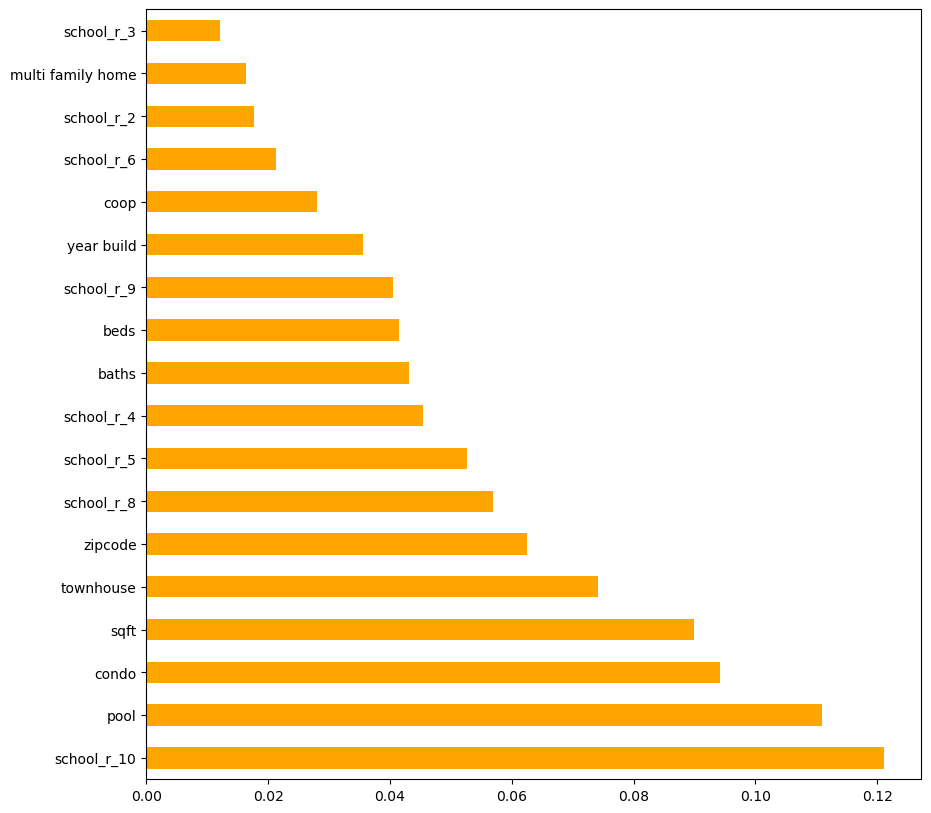

In [173]:
# вывод признаков
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(xgb_m.feature_importances_, index=X.columns)
feat_importances.nlargest(18).plot(kind='barh', color='orange');

# при данном количестве признаков качество модели практически не изменяется

In [174]:
# создание датасета с опредленными признаками как важные (выше на рисунке)
data_imp_f = data_cor[['school_r_10', 'pool', 'condo', 'sqft', 'townhouse', 'zipcode', 'school_r_8',
                       'school_r_8', 'school_r_4', 'baths', 'beds', 'school_r_9', 'year build', 'coop',
                       'school_r_6', 'school_r_2', 'multi family home', 'school_r_3', 'target']]

In [175]:
data_imp_f = data_imp_f.loc[:,~data_imp_f.columns.duplicated()]

In [176]:
# подготовка датасета
X = data_imp_f.drop(['target'], axis=1)
y = data_imp_f.target.values

# разделение датасета 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [177]:
xgb_imp_f = XGBRegressor()
xgb_imp_f.fit(X_train, y_train)

print(f'result in Test: {r2_score(y_test, xgb_imp_f.predict(X_test)):.3f}')
print(f'result in Train: {r2_score(y_train, xgb_imp_f.predict(X_train)):.3f}')

result in Test: 0.811
result in Train: 0.928


#### <span style="color:#32CD32"> Поле выбора важных параметров, качество прогноза модели практически не изменилось: 

## <span style="color:#1E90FF"> Оптимизация гиперпараметров модели, показавшей наилучший результат  </span>

In [ ]:
'''import optuna'''

In [ ]:
'''X_trainval, X_valid, y_trainval, y_valid = train_test_split(X_train, y_train, shuffle=True,  random_state=42)'''

In [ ]:
# гиперпараметры для оптимизации
'''def objective(trial):
    param = {
        'booster': 'gbtree',
        #'tree_method':'hist',  # this parameter means using the GPU when training our model to speedup the training process
        'sampling_method': 'gradient_based',
        'lambda': trial.suggest_loguniform('lambda', 7.0, 17.0),
        'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
        'eta': trial.suggest_categorical('eta', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 600),  
        'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5, 6, 7]),  
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'random_state': 42
    }

    model = XGBRegressor(**param)  
    
    model.fit(X_trainval, y_trainval, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10, verbose=False)
    
    predict = model.predict(X_valid)
    
    r_2 = r2_score(predict, y_valid)
    
    return r_2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50,  timeout=600)
    
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))'''

##### <span style="color:#1E90FF"> Оптимизация была в Google colab  </span>

Number of finished trials: 50
Best trial:
  Value: 0.6449884525635186
  Params: 
    lambda: 15.10150326488523
    alpha: 15.854309781355196
    eta: 0.9
    gamma: 24
    learning_rate: 0.014
    colsample_bytree: 1.0
    colsample_bynode: 1.0
    n_estimators: 786
    min_child_weight: 11
    max_depth: 7
    subsample: 1.0

In [ ]:
'''best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)'''


XGBRegressor
XGBRegressor(alpha=15.854309781355196, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=1.0,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eta=0.9, eval_metric=None,
             feature_types=None, gamma=24, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=15.10150326488523, learning_rate=0.014, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=11, missing=nan, monotone_constraints=None,
             n_estimators=786, n_jobs=None, ...)

#### <span style="color:#32CD32"> Результаты после оптимизации гиперпараметров: 

- Best model result in Test: 0.7834834288463935
- Best model result in Train: 0.8545341335982085

- После оптимизации результаты получились хуже, чем без оптимизации.

## <span style="color:#1E90FF"> Серилализация модели. Подготовка для создания Docker файла </span>

In [178]:
import pickle

# Производим сериализацию обученной модели
model = pickle.dumps(xgb_imp_f)

# Производим сериализацию и записываем результат в файл формата pkl
with open('model.pkl', 'wb') as output:
    pickle.dump(xgb_imp_f, output)

In [179]:
!pip freeze > requirements.txt